Import Library

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import requests
import json
import csv
import time

2023-06-02 15:11:03.761612: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0,end=None):
    plt.plot(time[start:end],series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

Read weather CSV file

In [3]:
file_path = 'weather.csv'
data=pd.read_csv(file_path, delimiter=',',header=11,skipinitialspace=True)
data.head(1)

,Year,Month,Day,Hour,Minute,Temperature,Total_Precipitation,Wind_Speed,Wind_Direction
0,2018,1,15,0,0,16.4,0.0,6.73,74.48


Load Data Training

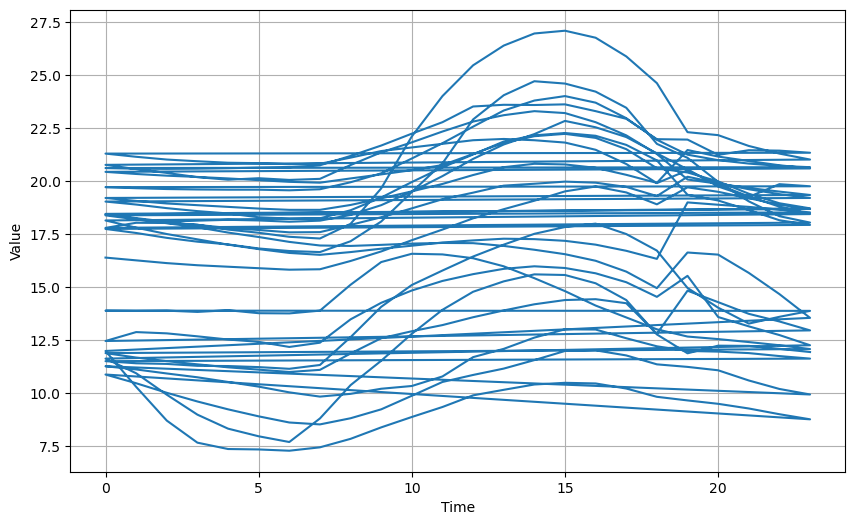

In [4]:
temperature = np.array(data['Temperature'])
time = np.array(data['Hour'])
num_periods = 24
f_horizon = 1
x_data = temperature[:(len(temperature)-(num_periods*2))]
x_batches = x_data.reshape(-1, num_periods, 1)

y_data = temperature[1:(len(temperature)-(num_periods*2))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)
# print(time)
# print(temperature)
# print(y_data)
# print(y_batches)
# print(y_batches.shape)
plt.figure(figsize=(10,6))
plot_series(time, temperature)

Loading Data Test

In [5]:
def test_data(series, forecast, num):
    testX = temperature[-(num + forecast):][:num].reshape(-1, num_periods, 1)
    testY = temperature[-(num):].reshape(-1, num_periods, 1)
    return testX, testY
X_test, Y_test = test_data(temperature, f_horizon, 24*2)
# print(X_test)
# print(X_test.shape)

In [7]:
import time
def get_weather(api_key, city):
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}"
    response = requests.get(url)
    data = json.loads(response.text)
    return data

def write_to_csv(data, filename):
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([data['dt'], data['weather'][0]['main'], data['weather'][0]['description'], data['main']['temp'], data['main']['humidity'], data['wind']['speed']])

# Thay thế 'YOUR_API_KEY' bằng API key của bạn từ OpenWeatherMap
api_key = '36c967526d6baa50490c7ff1ce49af04'

# Thay thế 'Ho Chi Minh City' bằng tên thành phố bạn muốn lấy dữ liệu thời tiết
city = 'Hanoi'

# Tạo file CSV và ghi tiêu đề các cột
filename = 'weather_data.csv'
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Timestamp', 'Weather', 'Description', 'Temperature (°C)', 'Humidity (%)', 'Wind Speed (m/s)'])
    
# Lấy dữ liệu thời tiết liên tục và ghi vào file CSV mỗi 10 phút
while True:
    def display_weather(data):
        if data["cod"] != "404":
            main_weather = data["weather"][0]["main"]
            description = data["weather"][0]["description"]
            temperature = data["main"]["temp"]
            humidity = data["main"]["humidity"]
            wind_speed = data["wind"]["speed"]
        
            print(f"Weather: {main_weather} - {description}")
            print(f"Temperature: {temperature}°C")
            print(f"Humidity: {humidity}%")
            print(f"Wind Speed: {wind_speed} m/s")
        else:
            print("City not found.")

    weather_data = get_weather(api_key, city)
    display_weather(weather_data)
    write_to_csv(weather_data, filename)
    print("Data written to CSV file.")
    time.sleep(6)  # Chờ 10 phút trước khi lấy dữ liệu tiếp theo

Weather: Clouds - overcast clouds
Temperature: 311.15°C
Humidity: 31%
Wind Speed: 2.8 m/s
Data written to CSV file.
Weather: Clouds - overcast clouds
Temperature: 311.15°C
Humidity: 31%
Wind Speed: 2.8 m/s
Data written to CSV file.
Weather: Clouds - overcast clouds
Temperature: 311.15°C
Humidity: 31%
Wind Speed: 2.8 m/s
Data written to CSV file.
Weather: Clouds - overcast clouds
Temperature: 311.15°C
Humidity: 31%
Wind Speed: 2.8 m/s
Data written to CSV file.
Weather: Clouds - overcast clouds
Temperature: 311.15°C
Humidity: 31%
Wind Speed: 2.8 m/s
Data written to CSV file.
Weather: Clouds - overcast clouds
Temperature: 311.15°C
Humidity: 31%
Wind Speed: 2.8 m/s
Data written to CSV file.
Weather: Clouds - overcast clouds
Temperature: 311.15°C
Humidity: 31%
Wind Speed: 2.8 m/s
Data written to CSV file.
Weather: Clouds - overcast clouds
Temperature: 311.15°C
Humidity: 31%
Wind Speed: 2.8 m/s
Data written to CSV file.


KeyboardInterrupt: 